In [1]:
# This is a Python adaptation from: https://github.com/parsifal9/RFlocalfdr

import sys

import numpy as np
import pandas as pd
import patsy
import scipy
import statsmodels.api as sm

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import patches
plt.rcParams['figure.figsize'] = [15, 10]


from varspark.stats.lfdr import LocalFdr
from varspark.hail.lfdrvs import LocalFdrVs

In [2]:
data = pd.read_csv('Letitia_CV_impurity_corrected.tsv', sep='\t')
importances = data.squeeze() #Transforming the dataframe into seriesis
importances

rs13303057     0.411473
rs112030046    2.066997
rs61766184     0.207114
rs35797206     0.200450
rs12117837     2.715201
                 ...   
rs12159714     0.552822
rs74702129     1.373624
rs55739335     0.157169
rs78225146     0.148426
rs8135083      0.210529
Name: x, Length: 4283, dtype: float64

<AxesSubplot:xlabel='x', ylabel='Count'>

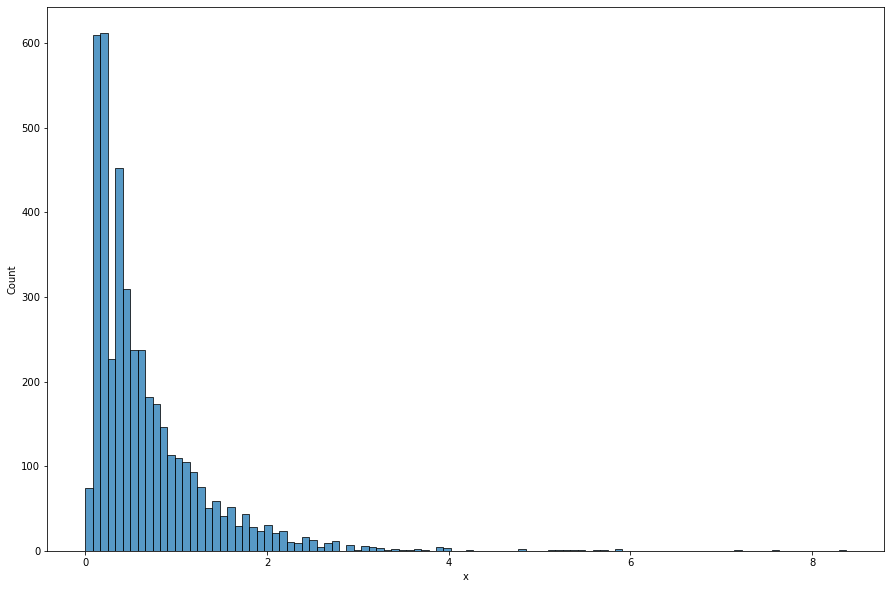

In [3]:
import seaborn as sns
sns.histplot(importances)

In [4]:
fdr_model = LocalFdr() #Create class
fdr_model.fit(importances) #Fit the model
fdr_model.get_pvalues() #get pvalues

array([4.88061586e-01, 1.82698945e-04, 7.51170579e-01, ...,
       8.21878487e-01, 8.34424543e-01, 7.46403130e-01])

In [5]:
fdr_model.get_fdr_cutoff() #Get fdr cutoff

0.0005137508976906281

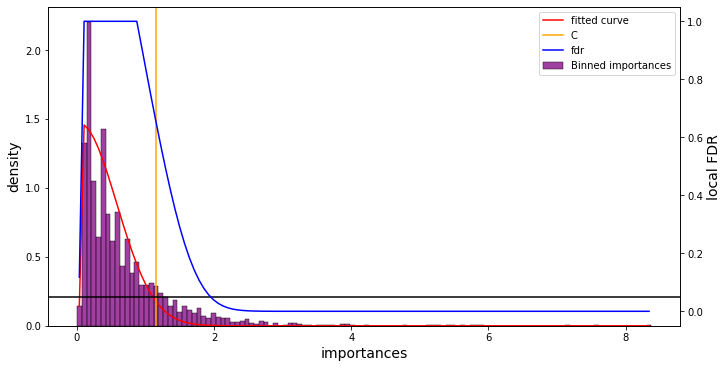

In [6]:
#Optional sanity check
_, ax = plt.subplots(figsize=(10, 5), layout='constrained')
fdr_model.plot(ax)
plt.show()

# With VS

In [7]:
import hail as hl
import varspark.hail as vshl
vshl.init()

using variant-spark jar at '/Users/reg032/workspace/VariantSpark/target/variant-spark_2.11-0.5.0-a0-dev0-all.jar'
22/06/07 13:30:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/07 13:30:18 WARN Hail: This Hail JAR was compiled for Spark 3.1.1, running with Spark 3.1.2.
  Compatibility is not guaranteed.
22/06/07 13:30:19 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
Running on Apache Spark version 3.1.2
SparkUI available at http://192.168.86.23:4041
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.74-0c3a74d12093
LOGGING: writing to /Users/reg032/workspace/VariantSpark/examples/hail-20220607-1330-0.2.74-0

In [8]:
from varspark.stats.lfdr import LocalFdr
from varspark.hail.lfdrvs import LocalFdrVs

In [9]:
vds = hl.import_vcf('../data/chr22_1000.vcf')
labels = hl.import_table('../data/chr22-labels-hail.csv', impute = True, delimiter=",").key_by('sample')
vds = vds.annotate_cols(label = labels[vds.s])
vds.cols().show(3)

rf_model = vshl.random_forest_model(y=vds.label['x22_16050408'],
                x=vds.GT.n_alt_alleles(), seed = 13, mtry_fraction = 0.05, min_node_size = 5, max_depth = 10)
rf_model.fit_trees(300, 50)

impTable = rf_model.variable_importance()



2022-06-07 13:30:24 Hail: WARN: Name collision: field 'sample' already in object dict. 
  This field must be referenced with __getitem__ syntax: obj['sample']
2022-06-07 13:30:24 Hail: INFO: Reading table to impute column types
2022-06-07 13:30:29 Hail: INFO: Finished type imputation            (0 + 1) / 1]
  Loading field 'sample' as type str (imputed)
  Loading field 'x22_16050408' as type int32 (imputed)
  Loading field 'x22_16050612' as type str (imputed)
  Loading field 'x22_16050678' as type str (imputed)
  Loading field 'x22_16050984' as type int32 (imputed)
  Loading field 'x22_16051107' as type int32 (imputed)
  Loading field 'x22_16051249' as type int32 (imputed)
  Loading field 'x22_16051347' as type int32 (imputed)
  Loading field 'x22_16051453' as type int32 (imputed)
  Loading field 'x22_16051477' as type int32 (imputed)
  Loading field 'x22_16051480' as type int32 (imputed)
2022-06-07 13:30:29 Hail: WARN: cols(): Resulting column table is sorted by 'col_key'.
    To pres

+-----------+--------------------+--------------------+--------------------+
| s         | label.x22_16050408 | label.x22_16050612 | label.x22_16050678 |
+-----------+--------------------+--------------------+--------------------+
| str       |              int32 | str                | str                |
+-----------+--------------------+--------------------+--------------------+
| "HG00096" |                  0 | "hahaha"           | "heheh"            |
| "HG00097" |                  1 | "ala ma"           | "1"                |
| "HG00099" |                  1 | "1"                | "1"                |
+-----------+--------------------+--------------------+--------------------+

+--------------------+--------------------+--------------------+
| label.x22_16050984 | label.x22_16051107 | label.x22_16051249 |
+--------------------+--------------------+--------------------+
|              int32 |              int32 |              int32 |
+--------------------+--------------------+--------------------+
|                  0 |                  0 |                  0 |
|                  0 |                  1 |                  1 |
|                  0 |                  1 |                  1 |
+--------------------+--------------------+--------------------+

+--------------------+--------------------+--------------------+
| label.x22_16051347 | label.x22_16051453 | label.x22_16051477 |
+--------------------+--------------------+--------------------+
|              int32 |              int32 |              int32 |
+--------------------+--------------------+--------------------+
|                  0 |                  0 |                  0 |
|                  1 |                  1 |                  0 |
|                  1 |                  1 |                  0 |
+--------------------+--------------------+--------------------+

+--------------------+
| label.x22_16051480 |
+--------------------+
|              int32 |
+--------------------+
|                  0 |
|                  1 |
|                  1 |
+--------------------+
showing top 3 rows

2022-06-07 13:30:35 Hail: INFO: Coerced almost-sorted dataset
2022-06-07 13:30:52 Hail: INFO: Coerced sorted dataset=======>      (8 + 1) / 9]


In [10]:
#Create Local FDR from VS hail 
fdrCalc = LocalFdrVs.from_imp_table(impTable)

In [11]:
# Get the local FDR from the model directly
fdrCalc = rf_model.get_lfdr()

2022-06-07 13:30:58 Hail: INFO: Coerced sorted dataset


In [12]:
# Compute the presumed best splitCount threshold
autoSplitCountTh = fdrCalc.find_split_count_th()
print("The automatically selected SplitCount Threshold is %s" % autoSplitCountTh)

The automatically selected SplitCount Threshold is 1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


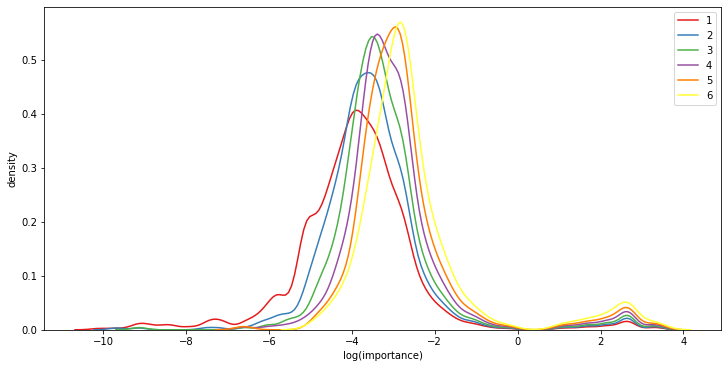

In [13]:
# Show densities for different splitcounts
fig, ax1 = plt.subplots(figsize=(10, 5), layout='constrained')
fdrCalc.plot_log_densities(ax1, min_split_count=1, max_split_count=6, find_automatic_best=False)
plt.show()

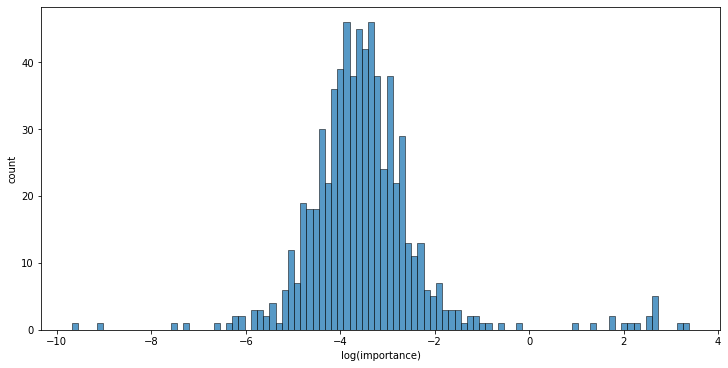

In [14]:
#Plot histogram for a selected threshold
fig, ax2 = plt.subplots(figsize=(10, 5), layout='constrained')
fdrCalc.plot_log_hist(ax2, 2)
plt.show()

In [15]:
#Get a table with the pvalues and the cutoff
fdrDF, fdr_corrected_cutoff = fdrCalc.compute_fdr(countThreshold = 2, fdr_cutoff = 0.05)
fdrDF, fdr_corrected_cutoff 

(           variant_id  logImportance        pvalue
 0     22_17705196_C_G      -9.685114  1.000000e+00
 1     22_17685358_C_T      -9.134216  1.000000e+00
 2    22_17774329_TC_T      -7.530889  9.999952e-01
 3     22_17763349_T_A      -7.214255  9.999780e-01
 4     22_17691887_C_T      -6.603883  9.996942e-01
 ..                ...            ...           ...
 682   22_16052838_T_A       2.698982  0.000000e+00
 683   22_16053509_A_G       2.703196  2.220446e-16
 684   22_16051480_T_C       2.732347  2.220446e-16
 685   22_16050678_C_T       3.224218  1.110223e-16
 686   22_16050408_T_C       3.387460  1.110223e-16
 
 [687 rows x 3 columns],
 0.021750802282878148)

In [16]:
hl.stop()